# INF2179 Group 1 Final Project

## Group 1: Rod Mazloomi, Marcus Emmanuel Barnes


### Data Set

S. Bansal, “Real / Fake Job Posting Prediction: Dataset of real and fake job postings”, Version 1, Feb., 2020. \[Online\]. Available:  https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction. [Accessed Nov. 16, 2021]

### Table of Contents
* [1. Import Libraries](#1)
* [2. Data Cleaning](#2)
    * [2.1. Load Data](#2.1)
    * [2.2. Clean Categorical Data](#2.2)
    * [2.3. Clean Text Data](#2.3)
    * [2.4. Export Cleaned Data](#2.4)
* [3. Data Visualization](#3)
    * [3.1. Load Clean Data from CSV](#3.1)
    * [3.2. Target Variable Analysis](#3.2)
    * [3.3. Categorical Variable Analysis](#3.3)
    * [3.4. Text Analysis](#3.4)
* [4. Model Prediction](#4)
    * [4.1. Load Data](#4.1)
    * [4.2. Encode Categorical Data](#4.2)
    * [4.3. Baseline Classifier](#4.3)
    * [4.4. TF-IDF Feature Extraction](#4.4)
    * [4.5. Random Forest Classification without SMOTE](#4.5)
    * [4.6. Random Forest Classification with SMOTE](#4.6)
    * [4.7. Conclusion](#4.7)

## 1. Import Libraries <a class="anchor" id="1"></a>

In [1]:
# General
import pandas as pd
import numpy as np
import string

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud

# Prediction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTETomek

# Natural Language Tool Kit
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rodmazloomi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rodmazloomi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Data Cleaning <a class="anchor" id="2"></a>

### 2.1. Load Data <a class="anchor" id="2.1"></a>

In [2]:
FILENAME = "fake_job_postings.csv"
INDEX = "job_id"

# Read from csv
df = pd.read_csv(FILENAME)

# Set index
df.set_index(INDEX, inplace=True)

# Display data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15185 non-null  object
 7   benefits             10670 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### 2.2. Clean Categorical Data <a class="anchor" id="2.2"></a>

#### Drop columns

In [3]:
# Drop columns that we will not be using for our analysis
columns_to_drop = ["location", "department", "salary_range", "industry"]
df.drop(columns_to_drop, axis=1, inplace=True)

#### Clean Binary columns

In [4]:
# Convert binary columns to boolean
bool_columns = ["telecommuting", "has_company_logo", "has_questions", "fraudulent"]
df[bool_columns] = df[bool_columns].astype("bool")

#### Clean Employment type

In [5]:
# Employment type codification
FULL_TIME = "Full-time"
PART_TIME = "Part-time"
OTHER = "Other"

# Map employment type values
df["employment_type"] = df["employment_type"].map({
    "Full-time": FULL_TIME,
    "Part-time": PART_TIME,
    "Other": OTHER,
    "Contract": OTHER,
    "Temporary": OTHER,
})

#### Clean Required experience

In [6]:
# Required experience codification
JUNIOR = "Junior"
STANDARD = "Standard"
SENIOR = "Senior"

# Map required experience values
df["required_experience"] = df["required_experience"].map({
    "Internship": JUNIOR,
    "Not Applicable": np.nan,
    "Mid-Senior level": STANDARD,
    "Associate": STANDARD,
    "Entry level": JUNIOR,
    "Executive": SENIOR,
    "Director": SENIOR
})

#### Clean Required education

In [7]:
# Required education codification
HIGHSCHOOL = "Highschool"
UNDERGRADUATE = "Undergraduate"
POSTGRADUATE = "Postgraduate"
Other = "Other"

# Map required education values
df["required_education"] = df["required_education"].map({
    "Bachelor's Degree": UNDERGRADUATE, 
    "Master's Degree": POSTGRADUATE,
    'High School or equivalent': HIGHSCHOOL, 
    'Unspecified': np.nan,
    'Some College Coursework Completed': HIGHSCHOOL, 
    'Vocational': OTHER, 
    'Certification': OTHER,
    'Associate Degree': UNDERGRADUATE, 
    'Professional': OTHER, 
    'Doctorate': POSTGRADUATE,
    'Some High School Coursework': HIGHSCHOOL, 
    'Vocational - Degree': OTHER,
    'Vocational - HS Diploma': OTHER
})

#### Clean Function

In [8]:
# Function codification
BUSINESS = "Business"
HEALTHCARE = "Healthcare"
INFORMATION_TECHNOLOGY = "Information Technology"
ENGINEERING = "Engineering"
DESIGN = "Design"
EDUCATION = "Education"
FINANCE = "Finance"
SCIENCE = "Science"
LEGAL = "Legal"
OTHER = "Other"

# Map function values
df["function"] = df["function"].map({
    'Marketing': BUSINESS, 
    'Customer Service': BUSINESS, 
    'Sales': BUSINESS,
    'Health Care Provider': HEALTHCARE, 
    'Management': BUSINESS, 
    'Information Technology': INFORMATION_TECHNOLOGY,
    'Other': OTHER, 
    'Engineering': ENGINEERING, 
    'Administrative': BUSINESS, 
    'Design': DESIGN, 
    'Production': BUSINESS,
    'Education': EDUCATION, 
    'Supply Chain': BUSINESS, 
    'Business Development': BUSINESS,
    'Product Management': BUSINESS, 
    'Financial Analyst': FINANCE, 
    'Consulting': BUSINESS,
    'Human Resources': BUSINESS, 
    'Project Management': BUSINESS, 
    'Manufacturing': BUSINESS,
    'Public Relations': BUSINESS, 
    'Strategy/Planning': BUSINESS, 
    'Advertising': BUSINESS, 
    'Finance': FINANCE,
    'General Business': BUSINESS, 
    'Research': OTHER, 
    'Accounting/Auditing': FINANCE,
    'Art/Creative': DESIGN, 
    'Quality Assurance': INFORMATION_TECHNOLOGY, 
    'Data Analyst': INFORMATION_TECHNOLOGY,
    'Business Analyst': BUSINESS, 
    'Writing/Editing': DESIGN, 
    'Distribution': BUSINESS, 
    'Science': SCIENCE,
    'Training': OTHER, 
    'Purchasing': BUSINESS, 
    'Legal': LEGAL
})

### 2.3. Clean Text Data <a class="anchor" id="2.3"></a>

#### Merge text data into one feature

In [9]:
text_columns = ["title", "company_profile", "description", "requirements", "benefits"]
TEXT_COLUMN_NAME = "text"

# Concatenate all text columns into one text column
df[TEXT_COLUMN_NAME] = df.loc[:, text_columns] \
    .fillna("") \
    .apply(lambda row: " ".join([row[col] for col in text_columns]), axis=1)

# Drop the previous text columns
df.drop(text_columns, axis=1, inplace=True)
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function,fraudulent,text
job_id,,,,,,,,,
1,False,True,False,Other,Junior,NaN,Business,False,"Marketing Intern We're Food52, and we've creat..."
2,False,True,False,Full-time,NaN,NaN,Business,False,Customer Service - Cloud Video Production 90 S...
3,False,True,False,NaN,NaN,NaN,NaN,False,Commissioning Machinery Assistant (CMA) Valor ...
4,False,True,False,Full-time,Standard,Undergraduate,Business,False,Account Executive - Washington DC Our passion ...
5,False,True,True,Full-time,Standard,Undergraduate,Healthcare,False,Bill Review Manager SpotSource Solutions LLC i...


#### Clean the text data

In [10]:
# Get stop words and a lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Create function to clean a string
def clean_text(text):
    cleaned_words = []
    
    # Split string and loop through words
    for word in text.split():
        
        # Remove whitespace
        word_lower = word.strip(" " + string.punctuation).lower()
        
        # Remove word if it is in stop words
        if word_lower in stop_words: continue
        
        # Lemmatize word
        word_lemmatized = lemmatizer.lemmatize(word_lower)
        cleaned_words.append(word_lemmatized)
        
    return " ".join(cleaned_words)

# Apply clean_text function to all the rows
df["text"] = df["text"].apply(clean_text)

### 2.4. Export Cleaned Data <a class="anchor" id="2.4"></a>

In [11]:
df.to_csv("cleaned_" + FILENAME)

## 3. Data Visualization <a class="anchor" id="3"></a>

### 3.1. Load Clean Data from CSV <a class="anchor" id="3.1"></a>

In [12]:
# Load from csv
df = pd.read_csv('./cleaned_fake_job_postings.csv')

# Set index to job_id
df.set_index("job_id", inplace=True)
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function,fraudulent,text
job_id,,,,,,,,,
1,False,True,False,Other,Junior,NaN,Business,False,marketing intern we're food52 we've created gr...
2,False,True,False,Full-time,NaN,NaN,Business,False,customer service cloud video production 90 se...
3,False,True,False,NaN,NaN,NaN,NaN,False,commissioning machinery assistant cma valor se...
4,False,True,False,Full-time,Standard,Undergraduate,Business,False,account executive washington dc passion impro...
5,False,True,True,Full-time,Standard,Undergraduate,Healthcare,False,bill review manager spotsource solution llc gl...


In [13]:
# Split job posting data into real and fake
real_data = df.loc[df["fraudulent"] == False,]
fake_data = df.loc[df["fraudulent"] == True,]

In [14]:
# Helper function to clean labels for plots
def clean_label_name(text):
    return text.replace("_", " ").title()

### 3.2. Target Variable Analysis <a class="anchor" id="3.2"></a>

In [15]:
# Get proportion of real and fake posts in dataset
print("Percentage of real and fake job postings: ")
pd.DataFrame(df["fraudulent"].value_counts(normalize=True))

Percentage of real and fake job postings: 


,fraudulent
False,0.951566
True,0.048434


We have a imbalalenced data set on our target variable 'fraudulent'. Our data is ~95% real job posts and ~5% fake job posts.

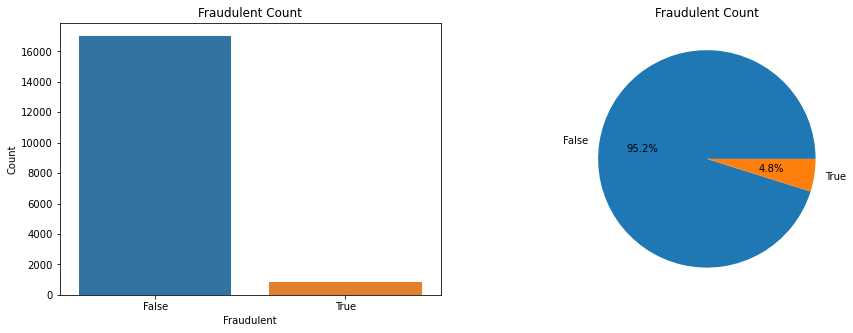

In [16]:
f, axes = plt.subplots(1, 2, figsize=(15, 5))
target_col = "fraudulent"
clean_label = clean_label_name(target_col)

# Create count plot to visualize real and fake post count
ax = sns.countplot(x=target_col, data=df, ax=axes[0])
ax.set(xlabel=clean_label, ylabel='Count', title=f'{clean_label} Count')

# Create pie chart to visualize proportion of real and fake posts
fraudulent_value_count = df[target_col].value_counts()
plt.pie(fraudulent_value_count, labels=fraudulent_value_count.index, autopct="%.1f%%")
plt.title(f'{clean_label} Count')

plt.show()

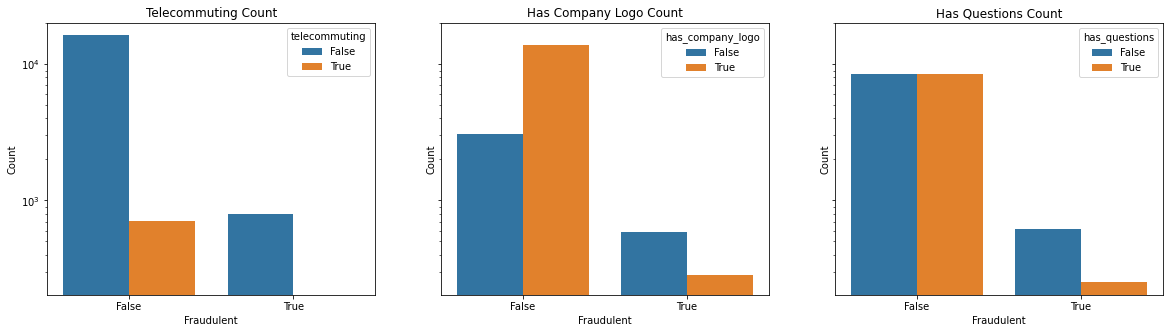

In [17]:
# For each binary column create a Count Plot grouped on whether it is fraudulent 
binary_columns = ["telecommuting", "has_company_logo", "has_questions"]
f, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
for i in range(len(binary_columns)):
    col = binary_columns[i]
    ax = axes[i]
    ax = sns.countplot(x="fraudulent", hue=col, data=df, ax=ax)
    ax.set(xlabel=clean_label_name("fraudulent"), ylabel='Count', title=f'{clean_label_name(col)} Count', yscale="log")
plt.show()

We can see in the second that plot that non-fraudulent posts are more likely to have a company logo. Fake posts have a smaller proportion of company logos. Lets explore this further:

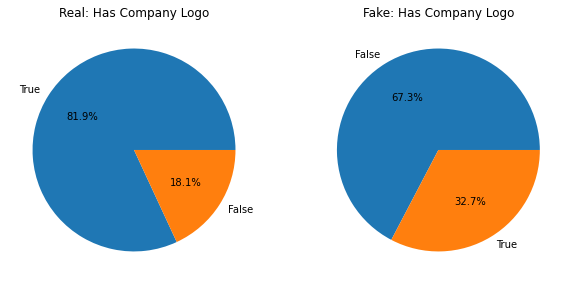

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
logo_col = "has_company_logo"

real_logo_value_counts = real_data[logo_col].value_counts()
fake_logo_value_counts = fake_data[logo_col].value_counts()

axs[0].pie(real_logo_value_counts, labels=real_logo_value_counts.index, autopct="%.1f%%")
axs[0].set_title("Real: " + clean_label_name(logo_col)) 

axs[1].pie(fake_logo_value_counts, labels=fake_logo_value_counts.index, autopct="%.1f%%")
axs[1].set_title("Fake: " + clean_label_name(logo_col)) 

plt.show()

Among real posts, ~81% contain a company logo. Among fake posts, ~32% contain a company logo.

### 3.3. Categorical Variable Analysis <a class="anchor" id="3.3"></a>

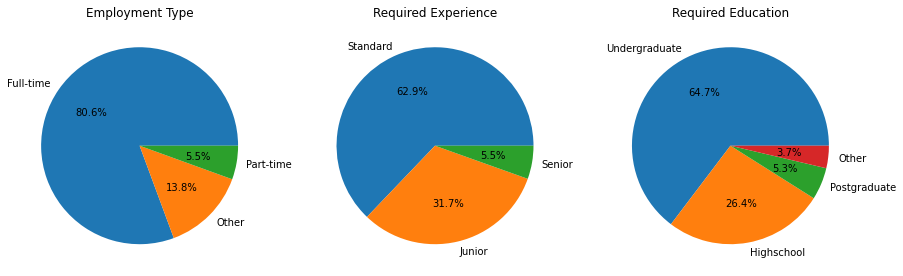

In [19]:
categorical_columns = ["employment_type", "required_experience", "required_education"]
fig, axs = plt.subplots(1, 3, figsize=(15,15))

# Loop through categorical columns and create a pie plot
for i in range(3):
    col = categorical_columns[i]
    col_value_counts = df[col].value_counts()
    
    axs[i].pie(col_value_counts, labels=col_value_counts.index, autopct="%.1f%%")
    axs[i].set_title(clean_label_name(col)) 

plt.show()

This is the distribution of the categorical data for the entire dataset. Lets see how this distribution differs for real and fake data:

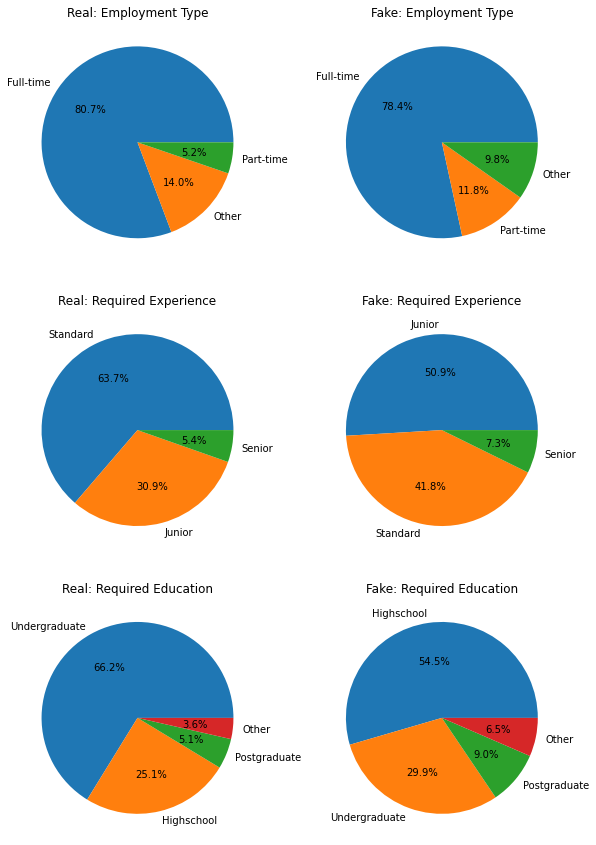

In [20]:
categorical_columns = ["employment_type", "required_experience", "required_education"]
fig, axs = plt.subplots(3, 2, figsize=(10,15))

# For each categorical column create one pie plot for real job posts and another for fake
for i in range(3):
    col = categorical_columns[i]
    real_value_count = real_data[col].value_counts()
    fake_value_count = fake_data[col].value_counts()
    
    # Create pie plot on real job posts
    axs[i, 0].pie(real_value_count, labels=real_value_count.index, autopct="%.1f%%")
    axs[i, 0].set_title("Real: " + clean_label_name(col)) 
    
    # Create pie plot on fake job posts
    axs[i, 1].pie(fake_value_count, labels=fake_value_count.index, autopct="%.1f%%")
    axs[i, 1].set_title("Fake: " + clean_label_name(col))

plt.show()

We can see on the second row that fake posts have a higher proportion of job posts that are looking for Junior experience. ~31% of real job posts are junior roles and ~51% of fake posts are junior roles.

In the third row, we can see that ~25% of real job posts require a minimum of highschool education as opposed to ~54% of fake job posts that require a minimum of highschool education.

### 3.4. Text Analysis <a class="anchor" id="3.4"></a>

In [21]:
# Create two strings, one containing all the words in real posts and the other fake posts 
real_text = " ".join(real_data["text"])
fake_text = " ".join(fake_data["text"])

#### Word Clouds

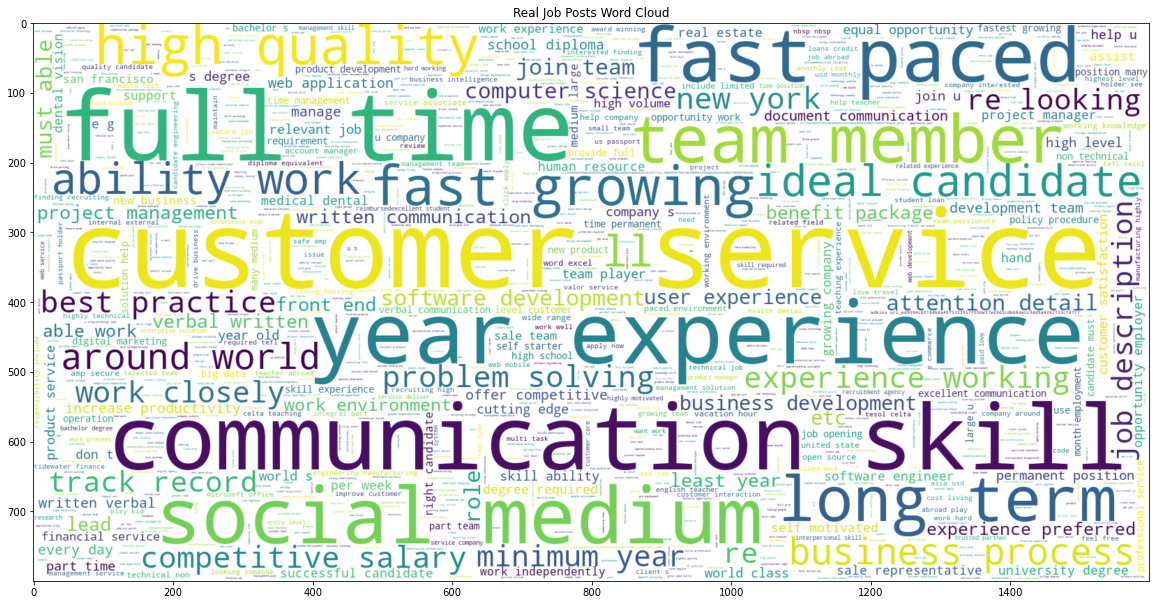

In [22]:
# Create a word cloud of words in real job posts
plt.figure(figsize = (20,20))

word_cloud = WordCloud(width = 1600 , height = 800 , max_words = 1000, background_color="white").generate(real_text)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title("Real Job Posts Word Cloud")
plt.show()

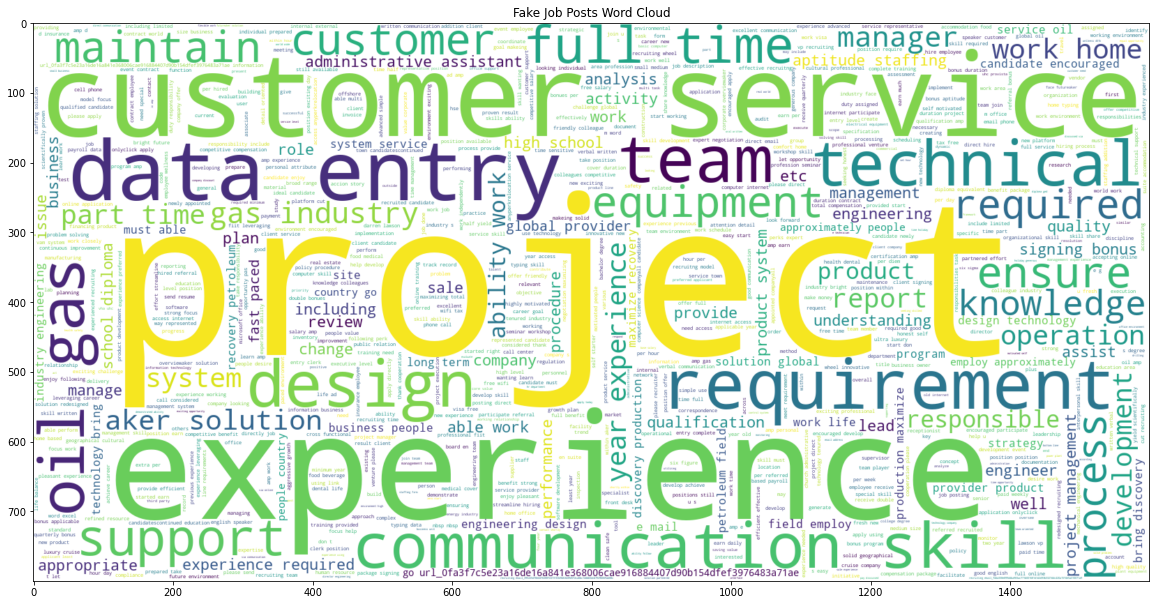

In [23]:
# Create a word cloud of words in fake job posts
plt.figure(figsize = (20,20))

word_cloud = WordCloud(width = 1600 , height = 800 , max_words = 1000, background_color="white").generate(fake_text)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title("Fake Job Posts Word Cloud")
plt.show()

In the fake job posts word cloud we can see some words that dont appear in the real job post word cloud, such as: "oil", "gas" and "data entry".

#### Word Counts

In [24]:
# Create a list of of the top 100 words used in real posts. Display 20 of them.
vectorizer = CountVectorizer(max_features=100)
X_real = vectorizer.fit_transform(df.loc[df["fraudulent"] == 0, "text"])
real_words_list = vectorizer.get_feature_names()
real_words_set = set(vectorizer.get_feature_names())
pd.DataFrame(X_real.toarray(), columns=real_words_list).sum(axis=0).sort_values(ascending=False).head(20)

experience     39463
team           37411
work           36770
company        28299
service        28154
customer       25894
business       23814
we             20505
client         19663
product        19147
new            17446
year           17100
management     16215
skill          16008
development    15945
sale           15656
time           15625
working        15584
amp            15459
job            14317
dtype: int64

In [25]:
# Create a list of of the top 100 words used in fake posts. Display 20 of them.
vectorizer = CountVectorizer(max_features=100)
X_fake = vectorizer.fit_transform(df.loc[df["fraudulent"] == 1, "text"])
fake_words_list = vectorizer.get_feature_names()
fake_words_set = set(vectorizer.get_feature_names())
pd.DataFrame(X_fake.toarray(), columns=fake_words_list).sum(axis=0).sort_values(ascending=False).head(20)

work           1829
experience     1610
service        1287
amp            1154
skill          1112
customer       1046
company         963
team            943
product         904
time            865
position        856
project         821
business        773
management      730
system          707
ability         688
year            676
data            651
engineering     633
industry        612
dtype: int64

In [26]:
# Display the top 100 words that are used in real posts and NOT in fake posts
pd.DataFrame(real_words_set.difference(fake_words_set), columns=["Real words"])

,Real words
0,one
1,life
2,developer
3,world
4,platform
5,growing
6,great
7,build
8,growth
9,you


In [27]:
# Display the top 100 words that are used in fake posts and NOT in real posts
pd.DataFrame(fake_words_set.difference(real_words_set), columns=["Fake Words"])

,Fake Words
0,operation
1,field
2,plan
3,per
4,entry
5,oil
6,duty
7,home
8,contract
9,gas


## 4. Model Prediction <a class="anchor" id="4"></a>

In [28]:
# Constants
FILENAME = "cleaned_fake_job_postings.csv"
INDEX = "job_id"
TARGET_VARIABLE = "fraudulent"
CATEGORICAL_COLUMNS = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "function", "fraudulent"]
CORPUS_COLUMN_NAME = "text"
TFIDF_MAX_FEATURES = 100
TFIDF_NGRAM_RANGE = (1,1)
RANDOM_STATE = 12345

### 4.1 Load data <a class="anchor" id="4.1"></a>

In [29]:
df = pd.read_csv(FILENAME)
df.set_index(INDEX, inplace=True)
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function,fraudulent,text
job_id,,,,,,,,,
1,False,True,False,Other,Junior,NaN,Business,False,marketing intern we're food52 we've created gr...
2,False,True,False,Full-time,NaN,NaN,Business,False,customer service cloud video production 90 se...
3,False,True,False,NaN,NaN,NaN,NaN,False,commissioning machinery assistant cma valor se...
4,False,True,False,Full-time,Standard,Undergraduate,Business,False,account executive washington dc passion impro...
5,False,True,True,Full-time,Standard,Undergraduate,Healthcare,False,bill review manager spotsource solution llc gl...


### 4.2 Encode Categorical data <a class="anchor" id="4.2"></a>

In [30]:
# Variable for to store our encoders, if we want to decode we have them stored here
encoders = {}

# Loop through all categorical columns and use Label Encoder to encode
for col in CATEGORICAL_COLUMNS:    
    le = preprocessing.LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])
    encoders[col] = le

df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function,fraudulent,text
job_id,,,,,,,,,
1,0,1,0,1,0,4,0,0,marketing intern we're food52 we've created gr...
2,0,1,0,0,3,4,0,0,customer service cloud video production 90 se...
3,0,1,0,3,3,4,10,0,commissioning machinery assistant cma valor se...
4,0,1,0,0,2,3,0,0,account executive washington dc passion impro...
5,0,1,1,0,2,3,5,0,bill review manager spotsource solution llc gl...


### 4.3. Baseline Classifier <a class="anchor" id="4.3"></a>

In [31]:
# Create our features and our target variable
X = df.drop(TARGET_VARIABLE, axis=1)
y = df.loc[:, TARGET_VARIABLE]

# Split our data set into 25% train and 75% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

# Train a 'most frequent' base classifier and get the accuracy of this model
bc = DummyClassifier(strategy="most_frequent")
bc.fit(X_train, y_train)
bc.score(X_test, y_test)

0.9516778523489933

The accuracy of our base model is 95%. That is pretty good and will be tough to beat. The reason for this good accuracy is because majority of our dataset is real job postings. We have an imbalanced dataset with regards to our target variable. Therefore if you were to guess the majority class you we will get a ~95% accuracy. Later on we will end up using the Synthetic Minority Oversampling Technique (SMOTE) to balance our dataset.

### 4.4. TF-IDF Feature Extraction <a class="anchor" id="4.4"></a>

In [32]:
# Create our features and target variable
X = df.drop(TARGET_VARIABLE, axis=1)
y = df.loc[:, TARGET_VARIABLE]

# Extract features from our text using TF-IDF
tf_idf = TfidfVectorizer(stop_words="english", ngram_range=TFIDF_NGRAM_RANGE, max_features=TFIDF_MAX_FEATURES)
tf_idf.fit(X[CORPUS_COLUMN_NAME])

# Append 'tfidf_' before each tfidf column name because we dont want any conflicts with our existing features
tf_idf_feature_names = "tfidf_" + np.array(tf_idf.get_feature_names(), dtype=object)
tf_idf_features = pd.DataFrame(tf_idf.transform(X[CORPUS_COLUMN_NAME]).toarray(), columns=tf_idf_feature_names, index=X.index)

# After we are done feature extraction drop our text data column
X = X.drop(CORPUS_COLUMN_NAME, axis=1).join(tf_idf_features)

### 4.5. Random Forest Classification without SMOTE <a class="anchor" id="4.5"></a>

In [33]:
# Use Stratified KFold with 10 folds
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
# Train and evaluate random forest classifier
rfc = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=RANDOM_STATE)
scores = cross_val_score(rfc, X, y, scoring='accuracy', cv=skf, n_jobs=-1)
scores

array([0.96923937, 0.97595078, 0.97203579, 0.97706935, 0.97315436,
       0.97706935, 0.97091723, 0.96868009, 0.97427293, 0.97651007])

In [34]:
# Get average accuracy between all folds
scores.mean()

0.9734899328859059

### 4.6. Random Forest Classification with SMOTE <a class="anchor" id="4.6"></a>

In [35]:
# Generate more observations for our minority class using SMOTETomek
smt = SMOTETomek(random_state=RANDOM_STATE)
X_res, y_res = smt.fit_resample(X, y)
print("Before\n", y.value_counts())
print("After\n", y_res.value_counts())

Before
 0    17014
1      866
Name: fraudulent, dtype: int64
After
 0    17014
1    17014
Name: fraudulent, dtype: int64


After using SMOTE we now have an equal amount of real job posts and fake job posts. We have 17014 observations in each class.

In [36]:
# Train and evaluate Random Forest Classifier after SMOTE generated data
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
rfc = RandomForestClassifier(n_estimators=100, criterion="entropy")
scores = cross_val_score(rfc, X_res, y_res, scoring='accuracy', cv=skf, n_jobs=-1)
scores

array([0.99559212, 0.99382897, 0.99353512, 0.99706142, 0.99441669,
       0.99559212, 0.9964737 , 0.99412283, 0.99353322, 0.99706055])

In [37]:
# Get the average accuracy between all folds
scores.mean()

0.995121674809532

### 4.7. Conclusion <a class="anchor" id="4.7"></a>

Our base classifier achieved an accuracy of \~95%. This is due to our dataset being imbalanced with regards to our target variable (\~95% real job posts, \~5% fake).

Using a RandomForestClassifier without SMOTE, we were able to achieve an accuracy of \~0.97%, an improvement of \~2% over our base classifier.

Using our RandomForestClassifier, and SMOTE to increase the number of minority observations in our dataset, we were able to achieve an accuracy of \~99%, an improvement of \~4% over our base classifier.